
[Aşama 1/2] Kaydedilmiş modeller bulunamadı. Eğitim başlıyor...
Eğitim verisi yükleniyor: hog_color_lbp_glcm_augmented_train_kucuk_2class.pkl
Test verisi yükleniyor: hog_color_lbp_glcm_augmented_test_kucuk_2class.pkl
Sınıflar: ['bird' 'drone']

PCA sonrası yeni öznitelik boyutu: 1794

[Aşama 2/2] En iyi bilinen parametrelerle modeller eğitiliyor ve değerlendiriliyor...

--- Model (SVM) TÜM Eğitim Verisiyle Eğitiliyor ---

--- MODEL (SVM) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

        bird       0.96      0.89      0.92       570
       drone       0.95      0.98      0.96      1128

    accuracy                           0.95      1698
   macro avg       0.95      0.94      0.94      1698
weighted avg       0.95      0.95      0.95      1698



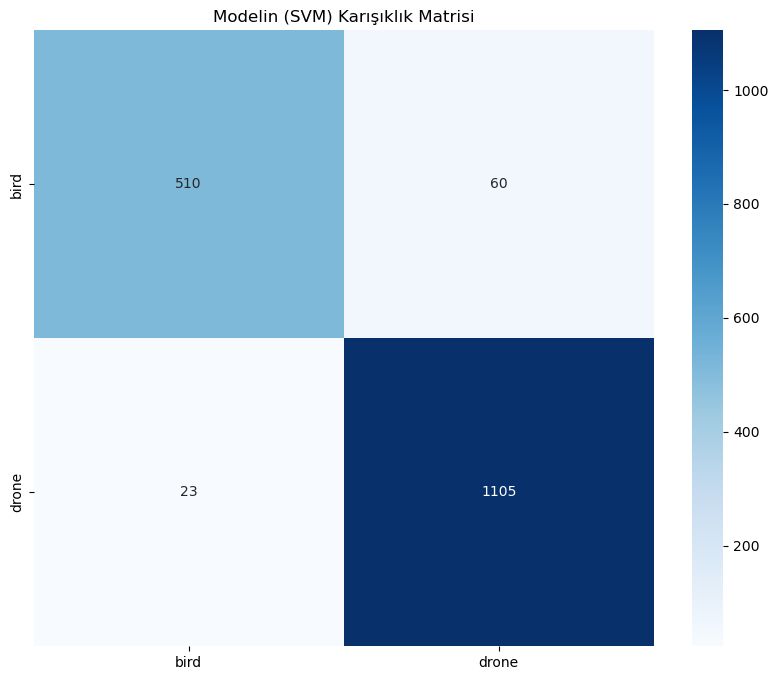


--- Model (MLP) TÜM Eğitim Verisiyle Eğitiliyor ---

--- MODEL (MLP) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

        bird       0.95      0.88      0.91       570
       drone       0.94      0.98      0.96      1128

    accuracy                           0.94      1698
   macro avg       0.94      0.93      0.94      1698
weighted avg       0.94      0.94      0.94      1698



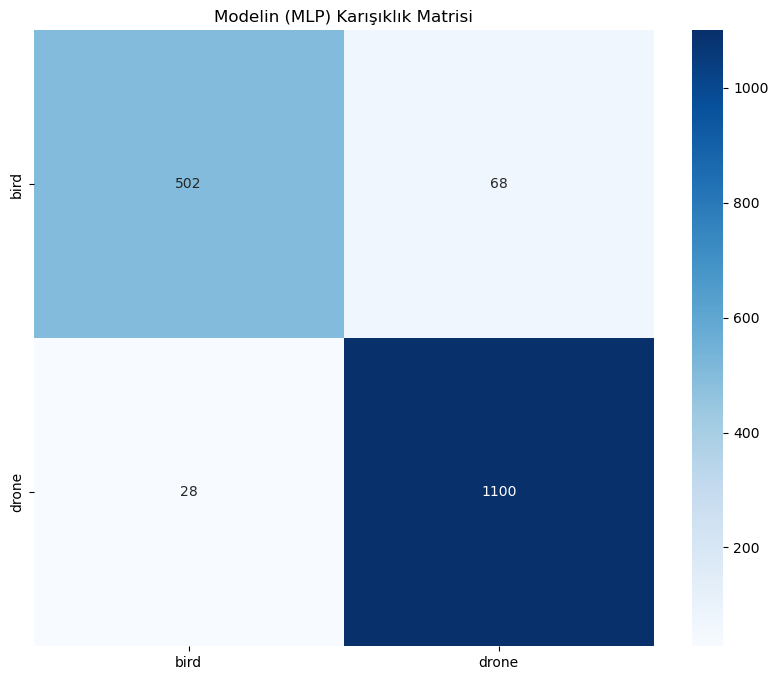


--- Model (XGBoost) TÜM Eğitim Verisiyle Eğitiliyor ---

--- MODEL (XGBoost) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

        bird       0.96      0.83      0.89       570
       drone       0.92      0.98      0.95      1128

    accuracy                           0.93      1698
   macro avg       0.94      0.91      0.92      1698
weighted avg       0.93      0.93      0.93      1698



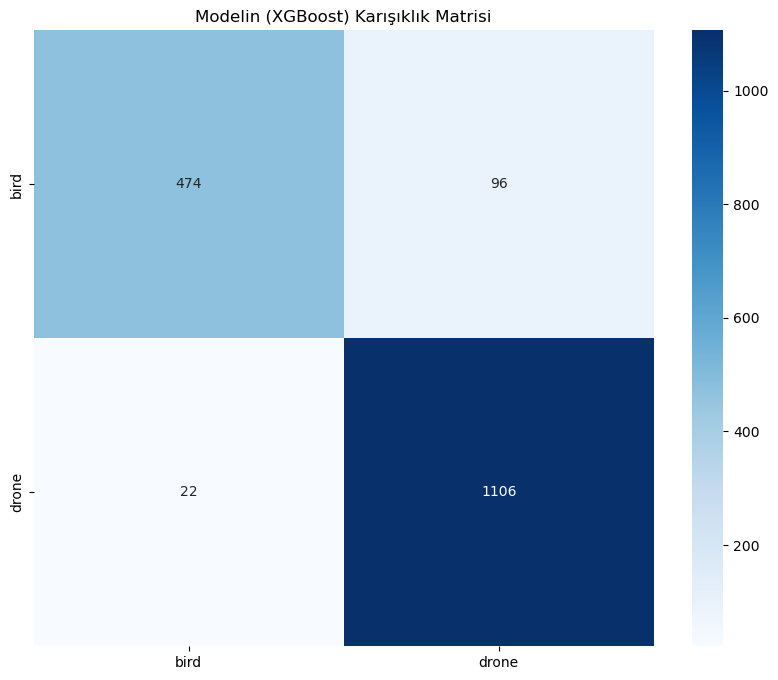

Tüm modeller ve yardımcılar 'all_trained_models_kucuk_2class_glcm_best_params.pkl' dosyasına kaydedildi.

Tespit aşaması başlıyor...
Piramit Katmanı 1, Ölçek: 1.00, Boyut: (1024, 1024)


Katman 1 taranıyor: 361it [01:07,  5.34it/s]


Piramit Katmanı 2, Ölçek: 1.50, Boyut: (682, 682)


Katman 2 taranıyor: 144it [00:16,  9.00it/s]


Piramit Katmanı 3, Ölçek: 2.26, Boyut: (454, 454)


Katman 3 taranıyor: 49it [00:06,  7.90it/s]


Piramit Katmanı 4, Ölçek: 3.39, Boyut: (302, 302)


Katman 4 taranıyor: 16it [00:02,  7.36it/s]


Piramit Katmanı 5, Ölçek: 5.09, Boyut: (201, 201)


Katman 5 taranıyor: 4it [00:00,  7.13it/s]


Piramit Katmanı 6, Ölçek: 7.64, Boyut: (134, 134)


Katman 6 taranıyor: 1it [00:00,  7.51it/s]


Toplam 1681 adet potansiyel nesne tespit edildi.

Sonuçlar filtreleniyor ve görselleştiriliyor...
Filtreleme sonrası 155 adet nesne kaldı.


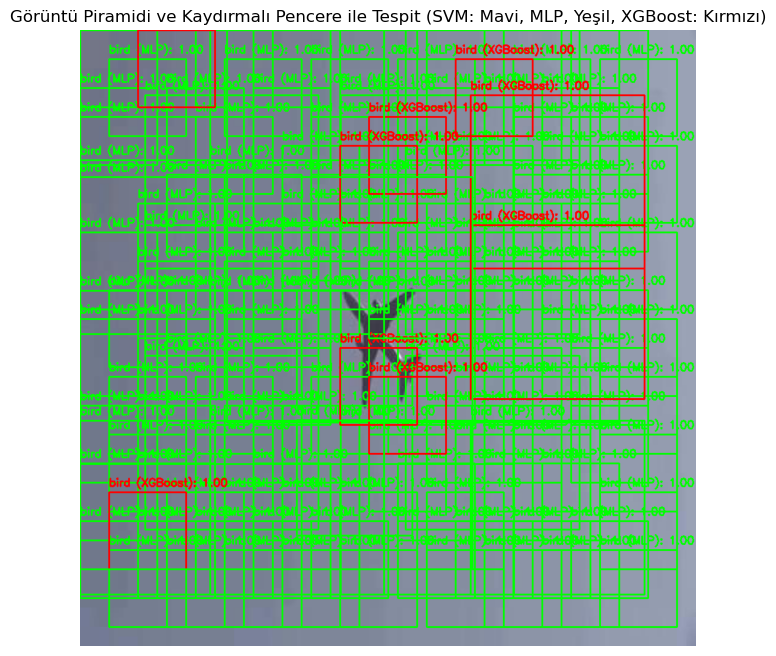

In [ ]:
import joblib
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

TRAIN_FEATURES_FILE = 'hog_color_lbp_glcm_augmented_train_kucuk_2class.pkl'
TEST_FEATURES_FILE = 'hog_color_lbp_glcm_augmented_test_kucuk_2class.pkl'
TEST_IMAGE_PATH = "test_goruntusu.jpg"
ALL_MODELS_FILE = 'all_trained_models_kucuk_2class_glcm_best_params.pkl'

BINS = 8
LBP_POINTS = 24
LBP_RADIUS = 8
GLCM_DISTANCES = [1, 2]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPERTIES = ['energy', 'contrast', 'homogeneity', 'correlation']
GLCM_LEVELS = 32

def extract_color_histogram(image, bins=(BINS, BINS, BINS)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(gray_image):
    lbp = local_binary_pattern(gray_image, LBP_POINTS, LBP_RADIUS, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist

def extract_glcm_features(gray_image):
    img_for_glcm = (gray_image / 255.0 * (GLCM_LEVELS - 1)).astype(np.uint8)
    glcm = graycomatrix(img_for_glcm, GLCM_DISTANCES, GLCM_ANGLES, levels=GLCM_LEVELS, symmetric=True, normed=True)
    glcm_features = [graycoprops(glcm, prop).flatten() for prop in GLCM_PROPERTIES]
    return np.concatenate(glcm_features)

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.5, minSize=(128, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] * (w / float(image.shape[1])))))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

if not os.path.exists(ALL_MODELS_FILE):
    print(f"\n[Aşama 1/2] Kaydedilmiş modeller bulunamadı. Eğitim başlıyor...")
    

    print(f"Eğitim verisi yükleniyor: {TRAIN_FEATURES_FILE}")
    train_data = joblib.load(TRAIN_FEATURES_FILE)
    X_train, y_train_text = train_data['features'], train_data['labels']

    print(f"Test verisi yükleniyor: {TEST_FEATURES_FILE}")
    test_data = joblib.load(TEST_FEATURES_FILE)
    X_test, y_test_text = test_data['features'], test_data['labels']

    le = LabelEncoder()
    le.fit(np.concatenate((y_train_text, y_test_text)))
    y_train = le.transform(y_train_text)
    y_test = le.transform(y_test_text)
    class_names = le.classes_
    print(f"Sınıflar: {class_names}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"\nPCA sonrası yeni öznitelik boyutu: {pca.n_components_}")

    print("\n[Aşama 2/2] En iyi bilinen parametrelerle modeller eğitiliyor ve değerlendiriliyor...")
    
    best_params = {
        'SVM': {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True, 'random_state': 42},
        'MLP': {'hidden_layer_sizes': (100,), 'alpha': 0.01, 'max_iter': 500, 'random_state': 42},
        'XGBoost': {'n_estimators': 200, 'learning_rate': 0.1, 'eval_metric': 'mlogloss', 'random_state': 42}
    }

    models_to_train = {
        'SVM': SVC(**best_params['SVM']),
        'MLP': MLPClassifier(**best_params['MLP']),
        'XGBoost': XGBClassifier(**best_params['XGBoost'])
    }
    
    trained_models = {}
    for name, model in models_to_train.items():
        print(f"\n--- Model ({name}) TÜM Eğitim Verisiyle Eğitiliyor ---")
        model.fit(X_train_pca, y_train)
        trained_models[name] = model
        
        print(f"\n--- MODEL ({name}) DEĞERLENDİRME RAPORU ---")
        y_pred = model.predict(X_test_pca)
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Modelin ({name}) Karışıklık Matrisi')
        plt.show()
  

    joblib.dump({
        'models': trained_models, 'scaler': scaler, 'pca': pca, 
        'le': le, 'class_names': class_names
    }, ALL_MODELS_FILE)
    print(f"Tüm modeller ve yardımcılar '{ALL_MODELS_FILE}' dosyasına kaydedildi.")

else:
    print(f"\nKaydedilmiş '{ALL_MODELS_FILE}' dosyası bulundu. Modeller doğrudan yükleniyor.")

if 'trained_models' not in locals():
    saved_data = joblib.load(ALL_MODELS_FILE)
    trained_models, scaler, pca, le, class_names = saved_data['models'], saved_data['scaler'], saved_data['pca'], saved_data['le'], saved_data['class_names']


print("\nTespit aşaması başlıyor...")

(winW, winH) = (128, 128)
step_size = 48
image = cv2.imread(TEST_IMAGE_PATH)
clone = image.copy()
detections = []

PIXELS_PER_CELL, CELLS_PER_BLOCK, ORIENTATIONS = (8, 8), (2, 2), 9

for i, resized in enumerate(pyramid(image, scale=1.5)):
    scale_factor = image.shape[1] / float(resized.shape[1])
    print(f"Piramit Katmanı {i+1}, Ölçek: {scale_factor:.2f}, Boyut: {resized.shape[:2]}")
    
    for (x, y, window) in tqdm(sliding_window(resized, step_size=step_size, window_size=(winW, winH)), desc=f"Katman {i+1} taranıyor"):
        if window.shape[0] != winH or window.shape[1] != winW: continue
        
        color_window = window
        gray_window = cv2.cvtColor(color_window, cv2.COLOR_BGR2GRAY)
        
        hog_features = hog(gray_window, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, block_norm='L2-Hys')
        color_features = extract_color_histogram(color_window)
        lbp_features = extract_lbp_features(gray_window)
        glcm_features = extract_glcm_features(gray_window)
        
        combined_features = np.concatenate([hog_features, color_features, lbp_features, glcm_features])
        features_scaled = scaler.transform([combined_features])
        features_pca = pca.transform(features_scaled)

        for model_name, model in trained_models.items():
            if model_name == 'XGBoost':
                confidence_threshold = 0.75
            elif model_name == 'MLP':
                confidence_threshold = 0.98
            else: # SVM
                confidence_threshold = 0.95 

            pred_proba = model.predict_proba(features_pca)[0]
            predicted_class_index = np.argmax(pred_proba)
            max_proba = pred_proba[predicted_class_index]
            
            if max_proba > confidence_threshold: 
                class_label = le.inverse_transform([predicted_class_index])[0]
                if class_label in ['bird', 'drone']:
                    startX, startY = int(x * scale_factor), int(y * scale_factor)
                    endX, endY = int((x + winW) * scale_factor), int((y + winH) * scale_factor)
                    box = (startX, startY, endX, endY)
                    detections.append((box, max_proba, class_label, model_name)) 

print(f"Toplam {len(detections)} adet potansiyel nesne tespit edildi.")

print("\nSonuçlar filtreleniyor ve görselleştiriliyor...")

final_detections = []
detections.sort(key=lambda d: d[1], reverse=True) 
while len(detections) > 0:
    best_detection = detections.pop(0)
    final_detections.append(best_detection)
    (box1, _, _, _) = best_detection
    remaining_detections = []
    for other_detection in detections:
        (box2, _, _, _) = other_detection
        (x1_a, y1_a, x2_a, y2_a) = box1
        (x1_b, y1_b, x2_b, y2_b) = box2
        xA, yA = max(x1_a, x1_b), max(y1_a, y1_b)
        xB, yB = min(x2_a, x2_b), min(y2_a, y2_b)
        interArea = max(0, xB - xA) * max(0, yB - yA)
        if interArea == 0:
            remaining_detections.append(other_detection)
            continue
        boxAArea = (x2_a - x1_a) * (y2_a - y1_a)
        boxBArea = (x2_b - x1_b) * (y2_b - y1_b)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        if iou < 0.3: 
            remaining_detections.append(other_detection)
    detections = remaining_detections

print(f"Filtreleme sonrası {len(final_detections)} adet nesne kaldı.")

model_colors = {'SVM': (255, 0, 0), 'MLP': (0, 255, 0), 'XGBoost': (0, 0, 255)}

for (box, proba, label, model_name) in final_detections:
    (startX, startY, endX, endY) = box
    color = model_colors.get(model_name, (255, 255, 255)) 
    cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
    label_text = f"{label} ({model_name}): {proba:.2f}"
    cv2.putText(clone, label_text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.title("Görüntü Piramidi ve Kaydırmalı Pencere ile Tespit (SVM: Mavi, MLP, Yeşil, XGBoost: Kırmızı)")
plt.axis('off')
plt.show()
